In [1]:
import cv2
import matplotlib.pyplot as plt
import PIL 
import os

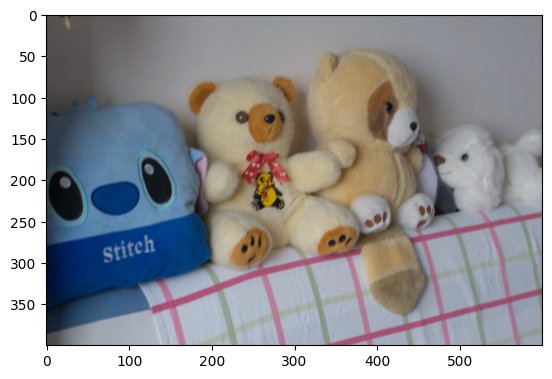

In [2]:
img_path = '/kaggle/input/lol-dataset/lol_dataset/our485/high/10.png'

img = cv2.imread(img_path)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)

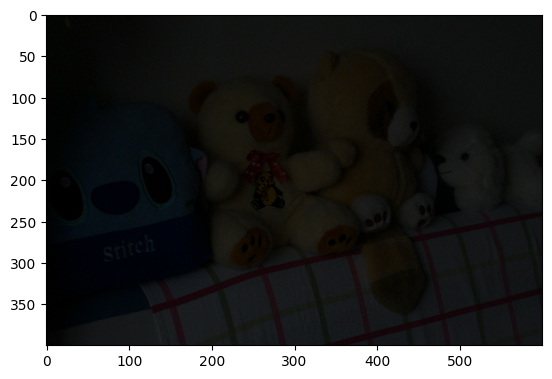

In [3]:
dark_img_path = '/kaggle/input/lol-dataset/lol_dataset/our485/low/10.png'

dark_img = cv2.imread(dark_img_path)

dark_img = cv2.cvtColor(dark_img, cv2.COLOR_BGR2RGB)


plt.imshow(dark_img)

In [4]:
img.shape

(400, 600, 3)

In [5]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image

In [7]:
def count_item(folder_path):
    num_files = 0
    for item in os.listdir(folder_path):
        num_files += 1
    return num_files

In [ ]:
dir = '/kaggle/input/lol-dataset/lol_dataset/our485/high'
for item in os.listdir(dir):
    id = item.split('.')[0]
    print(id)
    img_path = dir + '/' + item
    print(img_path)

In [9]:
list = os.listdir(dir)[0]
print(list)

641.png


/kaggle/input/lol-dataset/lol_dataset/our485/high/641.png


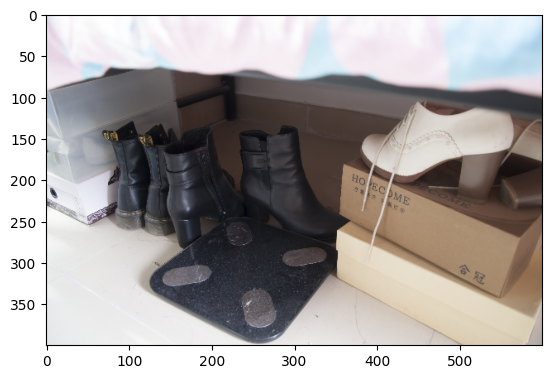

In [10]:
path = dir + '/' + list
print(path)
test_img = cv2.imread(path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
plt.imshow(test_img)

In [11]:
class DarkImageDataset(Dataset):
    def __init__(self, img_dir, dark_img_dir, transforms):
        self.img_dir = img_dir
        self.dark_img_dir = dark_img_dir
        self.transforms = transforms
    
    def __len__(self):
        return count_item(self.img_dir)
    def __getitem__(self, idx):
        img_name = os.listdir(self.img_dir)[idx]
        img_path = self.img_dir + '/' + img_name
        dark_img_path = self.dark_img_dir + '/' + img_name
        
        img = Image.open(img_path)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        dark_img = Image.open(dark_img_path)
        #dark_img = cv2.cvtColor(dark_img, cv2.COLOR_BGR2RGB)
        
        img = self.transforms(img)
        dark_img = self.transforms(dark_img)
        
        sample = (img, dark_img)
        
        return sample
        
        

In [12]:
data_transform = transforms.Compose([
    #transforms.Resize(size = (256, 256)),
    transforms.ToTensor()
])

In [13]:
train_img_dir_path = '/kaggle/input/lol-dataset/lol_dataset/our485/high'

train_dark_img_dir_path = '/kaggle/input/lol-dataset/lol_dataset/our485/low'

train_dataset = DarkImageDataset(train_img_dir_path, train_dark_img_dir_path, data_transform)


In [14]:
test_img_dir_path = '/kaggle/input/lol-dataset/lol_dataset/eval15/high'

test_dark_img_dir_path = '/kaggle/input/lol-dataset/lol_dataset/eval15/low'

test_dataset = DarkImageDataset(test_img_dir_path, test_dark_img_dir_path, data_transform)

In [ ]:
test_dataset.__getitem__(1)[0]

In [16]:
len(test_dataset)

15

In [21]:
img = test_dataset.__getitem__(0)

In [ ]:
print(img)

In [22]:
type(train_dataset)

__main__.DarkImageDataset

In [23]:
train_data_loader = DataLoader(train_dataset, batch_size = 4, shuffle = True, num_workers = 0)

test_data_loader = DataLoader(test_dataset, batch_size = 1, shuffle = False)

In [24]:
for batch, (X, y) in enumerate(train_data_loader):
    if batch > 10 :
        break
    print(X.shape)

torch.Size([4, 3, 400, 600])
torch.Size([4, 3, 400, 600])
torch.Size([4, 3, 400, 600])
torch.Size([4, 3, 400, 600])
torch.Size([4, 3, 400, 600])
torch.Size([4, 3, 400, 600])
torch.Size([4, 3, 400, 600])
torch.Size([4, 3, 400, 600])
torch.Size([4, 3, 400, 600])
torch.Size([4, 3, 400, 600])
torch.Size([4, 3, 400, 600])


In [25]:
for batch, (X, y) in enumerate(train_data_loader):
    if batch > 10 :
        break
    print(y.shape)

torch.Size([4, 3, 400, 600])
torch.Size([4, 3, 400, 600])
torch.Size([4, 3, 400, 600])
torch.Size([4, 3, 400, 600])
torch.Size([4, 3, 400, 600])
torch.Size([4, 3, 400, 600])
torch.Size([4, 3, 400, 600])
torch.Size([4, 3, 400, 600])
torch.Size([4, 3, 400, 600])
torch.Size([4, 3, 400, 600])
torch.Size([4, 3, 400, 600])


In [ ]:
for batch, (X, y) in enumerate(test_data_loader):
    print(y)

In [27]:
print(len(train_data_loader))

122


In [28]:
import torch
import torch.nn as nn

def autofit(feature1, feature2):
  for i in range(4):
    if feature1.shape[i] < feature2.shape[i]:
      if i == 2:
        zero_tensor = torch.zeros(feature1.shape[0], feature1.shape[1], 1, feature1.shape[3], device = 'cuda')
        feature1 = torch.cat([feature1, zero_tensor], dim = 2)
      if i == 3:
        zero_tensor = torch.zeros(feature1.shape[0], feature1.shape[1], feature1.shape[2], 1, device = 'cuda')
        feature1 = torch.cat([feature1, zero_tensor], dim = 3)
    if feature1.shape[i] > feature2.shape[i]:
      if i == 2:
        zero_tensor = torch.zeros(feature2.shape[0], feature2.shape[1], 1, feature2.shape[3], device = 'cuda')
        feature2 = torch.cat([feature2, zero_tensor], dim = 2)
      if i == 3:
        zero_tensor = torch.zeros(feature2.shape[0], feature2.shape[1], feature2.shape[2], 1, device = 'cuda')
        feature2 = torch.cat([feature2, zero_tensor], dim = 3)
  return feature1, feature2

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        self.down_conv1 = DoubleConv(in_channels, 64)
        self.down_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv2 = DoubleConv(64, 128)
        self.down_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv3 = DoubleConv(128, 256)
        self.down_pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv4 = DoubleConv(256, 512)
        self.down_pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bridge = DoubleConv(512, 1024)

        self.up_transpose1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up_conv1 = DoubleConv(1024, 512)
        self.up_transpose2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up_conv2 = DoubleConv(512, 256)
        self.up_transpose3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up_conv3 = DoubleConv(256, 128)
        self.up_transpose4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up_conv4 = DoubleConv(128, 64)

        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)


    def forward(self, x):
        # Encoder
        down1 = self.down_conv1(x)
        #print('down1:', down1.shape)
        pool1 = self.down_pool1(down1)
        down2 = self.down_conv2(pool1)
        #print('down2:', down2.shape)
        pool2 = self.down_pool2(down2)
        down3 = self.down_conv3(pool2)
        #print('down3:', down3.shape)
        pool3 = self.down_pool3(down3)
        down4 = self.down_conv4(pool3)
        #print('down4: ', down4.shape)
        pool4 = self.down_pool4(down4)

        # Bridge
        bridge = self.bridge(pool4)

        # Decoder
        up1 = self.up_transpose1(bridge)
        #print('up1:', up1.shape)
        up1, down4 = autofit(up1, down4)
        concat1 = torch.cat([up1, down4], dim=1)
        upconv1 = self.up_conv1(concat1)
        up2 = self.up_transpose2(upconv1)
        #print('up2: ', up2.shape)
        up2, down3 = autofit(up2, down3)
        concat2 = torch.cat([up2, down3], dim=1)
        upconv2 = self.up_conv2(concat2)
        up3 = self.up_transpose3(upconv2)
        #print('up3: ', up3.shape)
        up3, down2 = autofit(up3, down2)
        concat3 = torch.cat([up3, down2], dim=1)
        upconv3 = self.up_conv3(concat3)
        up4 = self.up_transpose4(upconv3)
        #print('up4: ', up4.shape)
        up4, down1 = autofit(up4, down1)
        concat4 = torch.cat([up4, down1], dim=1)
        upconv4 = self.up_conv4(concat4)

        out = self.out_conv(upconv4)
        return out

model  = UNet(in_channels = 3, out_channels = 3)

In [29]:
!pip install torchinfo
import torchinfo
from torchinfo import summary

In [31]:
summary(model, input_size=[1, 3, 380, 220])

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 3, 380, 220]          --
├─DoubleConv: 1-1                        [1, 64, 380, 220]         --
│    └─Sequential: 2-1                   [1, 64, 380, 220]         --
│    │    └─Conv2d: 3-1                  [1, 64, 380, 220]         1,792
│    │    └─BatchNorm2d: 3-2             [1, 64, 380, 220]         128
│    │    └─ReLU: 3-3                    [1, 64, 380, 220]         --
│    │    └─Conv2d: 3-4                  [1, 64, 380, 220]         36,928
│    │    └─BatchNorm2d: 3-5             [1, 64, 380, 220]         128
│    │    └─ReLU: 3-6                    [1, 64, 380, 220]         --
├─MaxPool2d: 1-2                         [1, 64, 190, 110]         --
├─DoubleConv: 1-3                        [1, 128, 190, 110]        --
│    └─Sequential: 2-2                   [1, 128, 190, 110]        --
│    │    └─Conv2d: 3-7                  [1, 128, 190, 110]        73,856
│ 

In [32]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [33]:
for batch, (X, y) in enumerate(train_data_loader):
    if batch > 3:
        break
    print(X.to(device).shape)
    print(y.to(device).shape)
    print(model.forward(X.to(device)).shape)

torch.Size([4, 3, 400, 600])
torch.Size([4, 3, 400, 600])
torch.Size([4, 3, 400, 600])
torch.Size([4, 3, 400, 600])
torch.Size([4, 3, 400, 600])
torch.Size([4, 3, 400, 600])
torch.Size([4, 3, 400, 600])
torch.Size([4, 3, 400, 600])
torch.Size([4, 3, 400, 600])
torch.Size([4, 3, 400, 600])
torch.Size([4, 3, 400, 600])
torch.Size([4, 3, 400, 600])


In [34]:
def train_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer):
    model.train()
    
    train_loss, train_acc = 0, 0
    
    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        y_pred = model(X)
        
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
    return train_loss


In [35]:
def test_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module):
    model.eval()
    test_loss, test_acc = 0, 0 
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            
            test_pred = model(X)
            
            loss = loss_fn(test_pred, y)
            
            test_loss += loss.item()
            
    test_loss = test_loss / len(dataloader)
    
    return test_loss

In [36]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module, train_dataloader: torch.utils.data.DataLoader,
         test_dataloader: torch.utils.data.DataLoader, optimizer: torch.optim.Optimizer,
         loss_fn: torch.nn.Module, epochs = 20):
    
    results = {"train_loss": [],
        "test_loss": []
    }
    
    for epoch in tqdm(range(epochs)):
        train_loss = train_step(model, train_dataloader, loss_fn, optimizer)
        test_loss = test_step(model, test_dataloader, loss_fn)
        
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"test_loss: {test_loss:.4f} | "
        )
        
        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)
        
    return results
    

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.01)

model_results = train(model = model, train_dataloader = train_data_loader, test_dataloader = test_data_loader, optimizer = optimizer, loss_fn = loss_fn, epochs = 40)

In [ ]:
'''
from PIL import Image

# Open the image
image = Image.open("/kaggle/working/frame_360_video1.png")

# Get the original width and height
width, height = image.size

# Calculate new width and height
new_width = int(width * 0.1)
new_height = int(height * 0.1)

# Resize the image
resized_image = image.resize((new_width, new_height))

plt.imshow(resized_image)

resized_image = resized_image.save('save_img.png')
'''

In [ ]:
'''
###
i = 0
for path in os.listdir('/kaggle/input/anti-spoofing/live_selfie'):
    image = Image.open('/kaggle/input/anti-spoofing/live_selfie/'+path)
    width, heigh = image.size
    # Calculate new width and height
    new_width = int(width * 0.1)
    new_height = int(heigh * 0.1)

    # Resize the image
    resized_image = image.resize((new_width, new_height))

    #plt.imshow(resized_image)

    resized_image = resized_image.save('/kaggle/working/live_selfie_resize/resize_img_'+str(i)+'.png')
    
    i = i + 1
'''

In [ ]:
'''
###
i = 0
for path in os.listdir('/kaggle/working/live_selfie_resize'):
    
    test_img = Image.open('/kaggle/working/live_selfie_resize/'+path)#replace with the path of an image

    test_img = data_transform(test_img)

    model_1.train()

    res = model_1(test_img.unsqueeze(dim = 0).to(device))

    transform = T.ToPILImage()

    img = transform(res.squeeze())

    #plt.imshow(img)
     
    path = '/kaggle/working/dark_live_selfie/dark_selfie_'+str(i)+'.png'
    
    img = img.save(path)
    
    i = i + 1
'''

In [37]:
import torch
import torchvision.transforms as T

In [ ]:
'''
#Change an image into dark image
import torch

import torchvision.transforms as T

torch.cuda.empty_cache()

test_img = Image.open('/kaggle/input/lol-dataset/lol_dataset/eval15/high/179.png')#replace with the path of an image

plt.imshow(test_img)

test_img = data_transform(test_img)

model.train()

res = model(test_img.unsqueeze(dim = 0).to(device))

print(res.shape)

print(res)

transform = T.ToPILImage()

img = transform(res.squeeze())

plt.imshow(img)
'''

In [ ]:
model_path = 'gen_dark_model_new_update.pth'

torch.save(model.state_dict(), model_path)

In [38]:
model_1 = UNet(in_channels = 3, out_channels = 3)
model_1.load_state_dict(torch.load('/kaggle/input/file-path/gen_dark_model_new_update.pth'))

<All keys matched successfully>

In [39]:
model_1 = model_1.to(device)

In [ ]:
img = Image.open('/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/Data/train/1/spoof/039842.jpg')

img = data_transform(img)

print(img.shape)

In [ ]:
!mkdir dark_spoof

In [ ]:
#Create output directory
for dir in os.listdir('/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/Data/train'):
    dir_name = '/kaggle/working/dark_spoof/'+dir
    os.makedirs(dir_name)

In [ ]:

model_1.train()
transform = T.ToPILImage()
for dir in os.listdir('/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/Data/train'):
    for sub_dir in os.listdir('/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/Data/train/'+dir):
        if sub_dir == 'spoof':
            for file in os.listdir('/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/Data/train/'+dir+'/'+'spoof'):
                if '.jpg' in file:
                    img_path = '/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/Data/train/'+dir+'/'+'spoof'+'/'+file
                    img = Image.open(img_path)
                    img = data_transform(img)
                    res = model_1(img.unsqueeze(dim = 0).to(device))
                    dark_img = transform(res.squeeze())
                    path = '/kaggle/working/dark_spoof/'+dir+'/'+'dark_'+file
                    dark_img = dark_img.save(path)

In [ ]:
'''
#Chạy thứ ba
i = 0
for path in os.listdir('/kaggle/working/replay_resize/vid09'):
    
    test_img = Image.open('/kaggle/working/replay_resize/vid09/'+path)#replace with the path of an image

    test_img = data_transform(test_img)

    model_1.train()

    res = model_1(test_img.unsqueeze(dim = 0).to(device))

    transform = T.ToPILImage()

    img = transform(res.squeeze())

    #plt.imshow(img)
     
    path = '/kaggle/working/dark_replay/vid09/dark_replay_img_'+str(i)+'.png'
    
    img = img.save(path)
    
    i = i + 1
'''

In [ ]:
'''
test_img = Image.open('/kaggle/working/resize_img8.png')#replace with the path of an image

test_img = data_transform(test_img)

model_1.train()

res = model_1(test_img.unsqueeze(dim = 0).to(device))

transform = T.ToPILImage()

img = transform(res.squeeze())

plt.imshow(img)

img = img.save('dark_live_selfie_8.png')
'''

In [ ]:
'''
i = 0
model.train()
transform = T.ToPILImage()
for path in os.listdir('/kaggle/input/anti-spoofing/live_selfie'):
    img = Image.open('/kaggle/input/anti-spoofing/live_selfie/'+path)
    img = data_transform(img)
    dark_img = model(img.unsqueeze(dim = 0).to(device))
    dark_img = transform(dark_img.squeeze())
    dark_img_path = 'dark_image_'+i+'.jpg'
    cv2.imwrite(dark_img_path, dark_img)
'''

In [ ]:
'''
#Chạy đầu tiên
import cv2
cap = cv2.VideoCapture('/kaggle/input/anti-spoofing/replay/0001ffba3c--62960f430bd50b2755f74916__Galaxy M31__M2003J15SG.mp4')
frame_rate = 30  # frames per second
interval_seconds = 0.5  # interval to capture frames (in seconds)
frame_interval = frame_rate * interval_seconds  # frames to skip each interval

frame_count = 0

while cap.isOpened():
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_count)

    ret, frame = cap.read()

    if not ret:
        print("Error reading frame")
        break
    cv2.imwrite(f"/kaggle/working/replay_frame/vid09/frame_{frame_count}_video9.png", frame)
    frame_count += frame_interval
    #if cv2.waitKey(25) & 0xFF == ord('q'):
        #break
    
#cap.release()
#cv2.destroyAllWindows()
'''

In [ ]:
'''
from PIL import Image

# Open the image
image = Image.open("/kaggle/working/frame_360_video1.png")

# Get the original width and height
width, height = image.size

# Calculate new width and height
new_width = int(width * 0.4)
new_height = int(height * 0.4)

# Resize the image
resized_image = image.resize((new_width, new_height))

plt.imshow(resized_image)

resized_image = resized_image.save('save_img.png')
'''

In [ ]:
'''
#Chạy thứ hai
i = 0
model.train()
transform = T.ToPILImage()
for path in os.listdir('/kaggle/working/replay_frame/vid09'):
    img = Image.open('/kaggle/working/replay_frame/vid09/'+path)
    width, heigh = img.size
    new_width = int(0.3 * width)
    new_heigh = int(0.3 * heigh)
    resized_img = img.resize((new_width, new_heigh))
    resized_img = resized_img.save('/kaggle/working/replay_resize/vid09/resize_img'+str(i)+'.png')
    i = i + 1
'''

In [ ]:
!zip -r file.zip /kaggle/working

In [40]:
!mkdir dark_dataset

In [41]:
!mkdir dark_dataset/fake

In [42]:
!mkdir dark_dataset/real

In [51]:
img = Image.open('/kaggle/input/dataset/fas_face_dataset/real/_1682414286471701_2.jpg')

img = data_transform(img)

print(img.shape)

torch.Size([3, 640, 480])


In [73]:
for path in os.listdir('/kaggle/input/dataset/fas_face_dataset/real'):
    img = Image.open('/kaggle/input/dataset/fas_face_dataset/real/' + path)
    
    
    w, h = img.size
    
    if w > 900 or h > 900:
        img = data_transform(img)
        print(img.shape)

torch.Size([3, 1088, 1088])
torch.Size([3, 720, 1280])
torch.Size([3, 1080, 1080])
torch.Size([3, 960, 720])
torch.Size([3, 960, 960])
torch.Size([3, 960, 720])
torch.Size([3, 1088, 1088])
torch.Size([3, 1088, 1088])
torch.Size([3, 1080, 1080])
torch.Size([3, 1088, 1088])
torch.Size([3, 1088, 1088])
torch.Size([3, 1088, 1088])
torch.Size([3, 960, 720])
torch.Size([3, 1280, 720])
torch.Size([3, 1088, 1088])
torch.Size([3, 1080, 1080])
torch.Size([3, 1088, 1088])
torch.Size([3, 960, 720])
torch.Size([3, 960, 960])
torch.Size([3, 1500, 1500])
torch.Size([3, 1088, 1088])
torch.Size([3, 1088, 1088])
torch.Size([3, 960, 960])
torch.Size([3, 1088, 1088])
torch.Size([3, 1088, 1088])
torch.Size([3, 1088, 1088])
torch.Size([3, 1088, 1088])
torch.Size([3, 1088, 1088])
torch.Size([3, 720, 1280])
torch.Size([3, 1088, 1088])
torch.Size([3, 960, 960])
torch.Size([3, 1088, 1088])
torch.Size([3, 1440, 1440])
torch.Size([3, 960, 720])
torch.Size([3, 1088, 1088])
torch.Size([3, 960, 720])
torch.Size([3, 

In [45]:
transform = T.ToPILImage()

In [ ]:
for dir in os.listdir('/kaggle/input/dataset/fas_face_dataset'):
    for path in os.listdir('/kaggle/input/dataset/fas_face_dataset/'+dir):
        img_path = '/kaggle/input/dataset/fas_face_dataset/' + dir + '/' + path
        img = Image.open(img_path)
        if dir == 'fake':
            width, heigh = img.size
            new_width = int(0.1 * width)
            new_heigh = int(0.1 * heigh)
            img = img.resize((new_width, new_heigh))
        if dir == 'real':
            width, heigh = img.size
            if width > 500 or heigh > 500
        img = data_transform(img)
        res = model_1(img.unsqueeze(dim = 0).to(device))
        dark_img = transform(res.squeeze())
        path = '/kaggle/working/dark_dataset/'+dir +'/'+path
        dark_img = dark_img.save(path)
        

In [74]:
for path in os.listdir('/kaggle/input/dataset/fas_face_dataset/real'):
    img_path = '/kaggle/input/dataset/fas_face_dataset/real/'+path
    img = Image.open(img_path)
    
    width, heigh = img.size
    if width > 800 or heigh > 800:
        new_width = int(0.5 * width)
        new_heigh = int(0.5 * heigh)
    img = img.resize((new_width, new_heigh))
    img = data_transform(img)
    res = model_1(img.unsqueeze(dim = 0).to(device))
    dark_img = transform(res.squeeze())
    path = '/kaggle/working/dark_dataset/real/'+path
    dark_img = dark_img.save(path)

In [76]:
!zip -r file.zip /kaggle/working/dark_dataset

  adding: kaggle/working/dark_dataset/ (stored 0%)
  adding: kaggle/working/dark_dataset/fake/ (stored 0%)
  adding: kaggle/working/dark_dataset/fake/IMG_0701_401.jpg (deflated 9%)
  adding: kaggle/working/dark_dataset/fake/IMG_0701_1802.jpg (deflated 7%)
  adding: kaggle/working/dark_dataset/fake/IMG_0700_1472.jpg (deflated 8%)
  adding: kaggle/working/dark_dataset/fake/IMG_0701_2370.jpg (deflated 9%)
  adding: kaggle/working/dark_dataset/fake/IMG_0700_2353.jpg (deflated 7%)
  adding: kaggle/working/dark_dataset/fake/IMG_0466.jpg (deflated 4%)
  adding: kaggle/working/dark_dataset/fake/IMG_0485.jpg (deflated 4%)
  adding: kaggle/working/dark_dataset/fake/IMG_0447.jpg (deflated 3%)
  adding: kaggle/working/dark_dataset/fake/IMG_0701_1718.jpg (deflated 7%)
  adding: kaggle/working/dark_dataset/fake/IMG_0701_31.jpg (deflated 8%)
  adding: kaggle/working/dark_dataset/fake/IMG_0700_587.jpg (deflated 7%)
  adding: kaggle/working/dark_dataset/fake/IMG_0443.jpg (deflated 4%)
  adding: kaggle/

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/dark_dataset/real/_16873148117258978_2.jpg'

In [75]:
i = 0
for path in os.listdir('/kaggle/working/dark_dataset/real'):
    i += 1
print(i)

438
